In [2]:
from extract_desserts import *
from pattern.text.en import singularize
from nltk import FreqDist
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(seed=2019)

import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    datefmt='%H:%M:%S',
                   level=logging.INFO)

from time import time
import multiprocessing

In [3]:
#load the raw data
# lets use the default value that only loads 250 recipes,
# instead of 1 million
raw_data = get_raw_data()
raw_ingredients = get_raw_ingredients()

Loading file  ../data/sample_layer1.json
Loading ingredient file: ../data/sample_det_ingrs.json


In [4]:
print('N recipes: {}\t N list of ingredients: {}'.format(len(raw_data),
      len(raw_ingredients)))


N recipes: 20000	 N list of ingredients: 20000


In [5]:
## get a list of desserts only
desserts, dessert_ings = find_desserts(raw_data, raw_ingredients)#,test_id='02916fd389')


['fish', 'salmon', 'tuna', 'chicken', 'turkey', 'garlic', 'onion', 'lamb', 'sausage', 'shrimp', 'beef', 'taco', 'shallot', 'veal', 'pork', 'mincemeat', 'crab', 'filet', 'chipotle', 'panceta', 'asparagus', 'parsley', 'mushroom', 'sardines', 'olives', 'oyster', 'ham', 'snow pea', 'kimchi', 'cilantro', 'Worcestershire', 'tomato paste', 'salsa', 'bologna']


In [6]:
total_recipes = len(raw_data)
dessert_recipes = len(desserts)
dessert_ingredients = len(dessert_ings)
print('Will look at {} dessert recipes, out of {} (~{:1.1f}%)'.format(
                            dessert_recipes, total_recipes,
                            dessert_recipes/total_recipes*100))

Will look at 3848 dessert recipes, out of 20000 (~19.2%)


In [7]:
def clean_dessert_ingredients(all_ingredients):
    count =0
    for item, ingredients_list in enumerate(all_ingredients):
        to_remove = []
        for ingr_item, ingredient in enumerate(ingredients_list['ingredients']):
            tmp_ingredient = ingredient['text'].lower().replace(' - ','-')
            tmp_ingredient = tmp_ingredient.replace("'",'')
            tmp_ingredient = tmp_ingredient.replace(" & ",'&')
            tmp_ingredient = tmp_ingredient.replace('fat free', 'fat-free')
#             tmp_ingredient = singularize(tmp_ingredient)
            
#             print(ingredient['text'].replace(' - ','-'))
            if re.search('water', tmp_ingredient) and not re.search('watermelon',tmp_ingredient) and not re.search('rose water',tmp_ingredient):
                to_remove.append(ingr_item)
            
            if re.search('vanilla extract', tmp_ingredient):
                tmp_ingredient='vanilla extract'

            elif (re.search('purpose flour', tmp_ingredient) 
                  or re.search('cake flour',tmp_ingredient) 
                  or re.search('rising flour', tmp_ingredient) 
                  or re.search('plain flour', tmp_ingredient)
                  or re.search('white flour', tmp_ingredient)
                  or re.search('raising flour', tmp_ingredient)

                 ):
                tmp_ingredient = 'flour' 
            elif re.search('brown sugar', tmp_ingredient) or re.search('demerara sugar', tmp_ingredient):
                tmp_ingredient = 'brown sugar'
            
            elif re.search('powdered sugar', tmp_ingredient) or re.search('confectioners sugar',tmp_ingredient) :
                tmp_ingredient ='powdered sugar'
            elif re.search('sugar', tmp_ingredient) or re.search('white sugar', tmp_ingredient) or re.search('granulated sugar',tmp_ingredient):
                tmp_ingredient = 'sugar'
            elif re.search('chocolate chip',tmp_ingredient):
#                 print(tmp_ingredient)
                tmp_ingredient = 'chocolate chip'
            elif re.search('semi-sweet', tmp_ingredient) and re.search('chocolate',tmp_ingredient):
                tmp_ingredient = 'chocolate'
            elif re.search('salted butter', tmp_ingredient):
                tmp_ingredient = 'butter'
            elif re.search('cocoa powder', tmp_ingredient):
                tmp_ingredient = 'cocoa powder'
            elif re.search('cinnamon', tmp_ingredient):
                tmp_ingredient = 'cinnamon'
            elif re.search('graham cracker', tmp_ingredient):
                tmp_ingredient = 'graham cracker'
            if not re.search('flour', tmp_ingredient) and not re.search('molasses',tmp_ingredient):
                tmp_ingredient = singularize(tmp_ingredient)


            all_ingredients[item]['ingredients'][ingr_item]['text'] = tmp_ingredient
            
        if len(to_remove)>0:
            
            to_remove.sort(reverse=True)
            
                
#             print(item,'to remove', to_remove)
            for i in to_remove:
#                 print('try to remove', all_ingredients[item]['ingredients'][i])
                del all_ingredients[item]['ingredients'][i]
#         for iremove in to_remove:
#             del all_ingredients
#         print('--------------------------')
        if item%500==0:
            logging.info("read {0} recipes".format(item))
    return all_ingredients

def print_dessert_ingredients(all_ingredients):
    count =0
    for item, ingredients_list in enumerate(all_ingredients):
        for ingr_item, ingredient in enumerate(ingredients_list['ingredients']):
            
            
            print(ingredient['text'])
        
        print('--------------------------')
        if item==50:
            break
    return all_ingredients

In [8]:
clean_ingredients =  clean_dessert_ingredients(dessert_ings);
# print_dessert_ingredients(clean_ingredients)
# print(dessert_ings)


11:03:19 : INFO : read 0 recipes
11:03:19 : INFO : read 500 recipes
11:03:19 : INFO : read 1000 recipes
11:03:19 : INFO : read 1500 recipes
11:03:20 : INFO : read 2000 recipes
11:03:20 : INFO : read 2500 recipes
11:03:20 : INFO : read 3000 recipes
11:03:20 : INFO : read 3500 recipes


In [6]:
# item = np.random.randint(dessert_recipes)
# print(item, dessert_ings[item]['valid'])
# dessert_ings[item]['ingredients']

In [10]:
m = re.match('onion', 'yellow onions' )
print(m)

m = re.search('onion', 'yellow onions' )
print(m)

None
<re.Match object; span=(7, 12), match='onion'>


# Let's look at the unique words

In [6]:
spices =['sugar','salt','water','baking soda','baking powder','flour', 'vegetable oil',
        'olive oil', 'cornstarch','nutmeg','white sugar','powdered sugar', 'brown sugar',
        'margarine','oil','shortening','kosher salt',"confectioners' sugar",'icing sugar',
        'canola oil','pepper' ,'low - fat milk','light corn syrup','cooking spray', 
         'corn syrup','vegetable shortening']

In [9]:
item=0
len(dessert_ings),len(dessert_ings[item]['ingredients'])

(4659, 5)

## Lets create a list of ingredients
And we will us it as an input to word2Vec

In [24]:
ingredients_per_recipe = []
count =0
for drecipe in dessert_ings:
    ings =[]
    for entry in drecipe['ingredients']:
        ings.append(entry['text'])
    ingredients_per_recipe.append(ings)
    count += 1
    if count%500==0:
        logging.info("read {0} ingredients".format(count))

#         break;

# print(all_dingredients)

11:08:44 : INFO : read 500 ingredients
11:08:44 : INFO : read 1000 ingredients
11:08:44 : INFO : read 1500 ingredients
11:08:44 : INFO : read 2000 ingredients
11:08:44 : INFO : read 2500 ingredients
11:08:44 : INFO : read 3000 ingredients
11:08:44 : INFO : read 3500 ingredients


In [26]:
ingredients_per_recipe[0]

['fresh rhubarb',
 'frozen rhubarb',
 'sugar',
 'strawberry jell-o gelatin dessert',
 'white cake mix',
 'butter']

## Create a Word2Vec model training on the ingredients. 


In [33]:
vec_size = 100;
model = gensim.models.Word2Vec(
   # all_dingredients,
    size=vec_size,
    window=5,
    min_count=20,
    workers=10,
    alpha=0.02,
    iter=4,
    sg=0)

In [34]:
t = time()
model.build_vocab(ingredients_per_recipe, progress_per=1000)

11:27:17 : INFO : collecting all words and their counts
11:27:17 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
11:27:17 : INFO : PROGRESS: at sentence #1000, processed 8804 words, keeping 1197 word types
11:27:17 : INFO : PROGRESS: at sentence #2000, processed 17590 words, keeping 1791 word types
11:27:17 : INFO : PROGRESS: at sentence #3000, processed 26079 words, keeping 2240 word types
11:27:17 : INFO : collected 2584 word types from a corpus of 33775 raw words and 3848 sentences
11:27:17 : INFO : Loading a fresh vocabulary
11:27:17 : INFO : min_count=20 retains 172 unique words (6% of original 2584, drops 2412)
11:27:17 : INFO : min_count=20 leaves 27382 word corpus (81% of original 33775, drops 6393)
11:27:17 : INFO : deleting the raw counts dictionary of 2584 items
11:27:17 : INFO : sample=0.001 downsamples 58 most-common words
11:27:17 : INFO : downsampling leaves estimated 10646 word corpus (38.9% of prior 27382)
11:27:17 : INFO : estimated required

In [36]:
model.train(ingredients_per_recipe, total_examples=model.corpus_count,
           epochs=40, report_delay=1)

11:27:25 : WARNING : Effective 'alpha' higher than previous training cycles
11:27:25 : INFO : training model with 10 workers on 172 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
11:27:25 : INFO : worker thread finished; awaiting finish of 9 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 8 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 7 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 6 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 5 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 4 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 3 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 2 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 1 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 0 more threads
11:27:25 : INFO : EPOCH - 1 : 

11:27:25 : INFO : worker thread finished; awaiting finish of 7 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 6 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 5 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 4 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 3 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 2 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 1 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 0 more threads
11:27:25 : INFO : EPOCH - 10 : training on 33775 raw words (10605 effective words) took 0.0s, 571486 effective words/s
11:27:25 : INFO : worker thread finished; awaiting finish of 9 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 8 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 7 more threads
11:27:25 : INFO : worker thread finished; awa

11:27:25 : INFO : worker thread finished; awaiting finish of 3 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 2 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 1 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 0 more threads
11:27:25 : INFO : EPOCH - 19 : training on 33775 raw words (10635 effective words) took 0.0s, 599496 effective words/s
11:27:25 : INFO : worker thread finished; awaiting finish of 9 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 8 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 7 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 6 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 5 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 4 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 3 more threads
11:27:25 : INFO : worker thread finished; awa

11:27:25 : INFO : EPOCH - 28 : training on 33775 raw words (10785 effective words) took 0.0s, 624579 effective words/s
11:27:25 : INFO : worker thread finished; awaiting finish of 9 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 8 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 7 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 6 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 5 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 4 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 3 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 2 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 1 more threads
11:27:25 : INFO : worker thread finished; awaiting finish of 0 more threads
11:27:25 : INFO : EPOCH - 29 : training on 33775 raw words (10657 effective words) took 0.0s, 505321 effective words/s
11

11:27:26 : INFO : worker thread finished; awaiting finish of 6 more threads
11:27:26 : INFO : worker thread finished; awaiting finish of 5 more threads
11:27:26 : INFO : worker thread finished; awaiting finish of 4 more threads
11:27:26 : INFO : worker thread finished; awaiting finish of 3 more threads
11:27:26 : INFO : worker thread finished; awaiting finish of 2 more threads
11:27:26 : INFO : worker thread finished; awaiting finish of 1 more threads
11:27:26 : INFO : worker thread finished; awaiting finish of 0 more threads
11:27:26 : INFO : EPOCH - 38 : training on 33775 raw words (10672 effective words) took 0.0s, 582798 effective words/s
11:27:26 : INFO : worker thread finished; awaiting finish of 9 more threads
11:27:26 : INFO : worker thread finished; awaiting finish of 8 more threads
11:27:26 : INFO : worker thread finished; awaiting finish of 7 more threads
11:27:26 : INFO : worker thread finished; awaiting finish of 6 more threads
11:27:26 : INFO : worker thread finished; awa

(425514, 1351000)

In [37]:
model.init_sims(replace=True)

11:27:36 : INFO : precomputing L2-norms of word weight vectors


In [42]:
w1='almond'
w1='rum'
model.wv.most_similar(positive=w1, topn=4)

[('nonfat milk', 0.7077823877334595),
 ('pie shell', 0.6262170672416687),
 ('ice cream', 0.5694143772125244),
 ('pumpkin', 0.537594735622406)]

In [45]:
w1='rum'
model.wv.most_similar(positive=['apple','banana'],
                      negative=['rum'],topn=10)

[('rolled oat', 0.7477458119392395),
 ('whole wheat flour', 0.7321438789367676),
 ('oat', 0.6760835647583008),
 ('date', 0.663547158241272),
 ('applesauce', 0.661933183670044),
 ('unsweetened applesauce', 0.6531609892845154),
 ('oatmeal', 0.6414744853973389),
 ('walnut', 0.5976195931434631),
 ('zucchini', 0.5864806175231934),
 ('shredded coconut', 0.5629600882530212)]

In [82]:
# witem = model.wv.__getitem__(['ginger'])
# witem[0]

In [48]:
model.wv.doesnt_match(['apple','butter','banana',
                       'rum','flour'])

'butter'

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [57]:
def ingredient_scatterplot(model, word, list_names):
    # create an array with the same size as the vector
    arrays = np.empty((0,vec_size), dtype='f')
    # set the original word,     
    word_labels = [word]
    color_list = ['red']
    # append the vector for the test word
    arrays = np.append(arrays, model.wv.__getitem__([word]),axis=0)
    
    ####### get the closest words and make then blue
    #get a list of the most similar words
    close_words = model.wv.most_similar([word])
    
    for word_score in close_words:
        # for each word get the vector  
        word_vector = model.wv.__getitem__([word_score[0]])
        # get the name
        word_labels.append(word_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, word_vector, axis=0)
     
    # get the words passed in the third entry and 
    # get those vectors, and set the color as green
    for wrd in list_names:
        word_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, word_vector, axis=0)
        
    Y = PCA(n_components=2).fit_transform(arrays)
    
#     np.set_printoptions(suppress=True)
    
#     Y = TSNE(n_components=2, random_state=0, 
#              perplexity=15).fit_transform(reduc)
    df = pd.DataFrame({'x':[x for x in Y[:, 0]],
                       'y':[y for y in Y[:,1]],
                      'words':word_labels,
                      'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(8,6)
    
    p1 = sns.regplot(data=df, 
                    x='x',y='y',fit_reg=False,
                    marker='x',
                    scatter_kws={'s':40,
                                'facecolors':df['color']})
    
    for line in range(df.shape[0]):
        p1.text(df['x'][line],df['y'][line],
               '  '+df['words'][line].title(),
               horizontalalignment='left',
                verticalalignment='bottom',size='large',
                color=df['color'][line],weight='normal'
               ).set_size(10)
        
    plt.xlim(Y[:,0].min(), Y[:,0].max() )
    plt.ylim(Y[:,1].min(), Y[:,1].max() )
    
    plt.title('t-SNE visualization for {}'.format(word.title()))

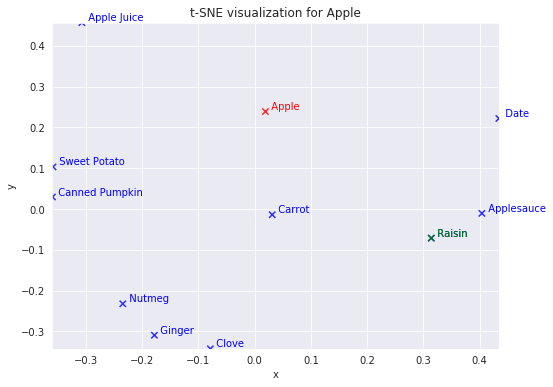

In [59]:
ingredient_scatterplot(model, 'apple', ['raisin'])

In [68]:
test_word = 'ginger'

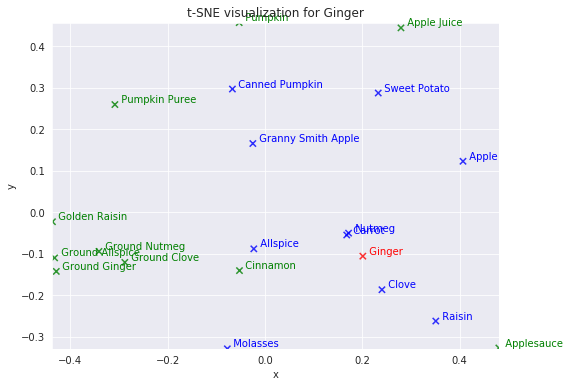

In [69]:
ingredient_scatterplot(model, test_word, [t[0] for t in model.wv.most_similar(positive=[test_word], topn=20)][10:])

## look at unique values

In [84]:
import re

spice_list = ['sugar','salt','water','baking soda','baking powder','flour', 'oil',
         'cornstarch','sugar','margarine','shortening','pepper' ,'milk','light corn syrup','cooking spray', 
         'corn syrup', 'butter']

def is_it_an_ingredient(ingredient):
    for spice in spice_list:
        if re.search(spice, ingredient):
#             print( ingredient,' -> ingredient is a spice')
            return False, spice
#     print('Did not find ingredient in the list of spices')    
    return True, ingredient

In [21]:
# create bag of ingredients

all_ingredients = []

for recipe_ings in clean_ingredients:# dessert_ings:
    n_ingredients = len(recipe_ings['valid'])
    for item, ingredient in enumerate(recipe_ings['ingredients']):
#         if recipe_ings['valid'][item] ==True:
#         ingred = ingredient['text'].lower()
#             ingred = singularize(ingred)
#             if ingred=='eggs':
#                 ingred='egg'
#             elif 'butter' in ingred:
#                 ingred = 'butter'
            
#             elif ingred == 'granulated sugar':
#                 ingred= 'sugar'
#             elif 'flour' in ingred:
#                 ingred = 'flour'
#             elif ingred == 'all - purpose flour' or ingred == 'cake flour':
#                 ingred = 'flour'
#             elif ingred == 'boiling water' or  ingred=='cold water':
#                 ingred = 'water'
#             elif ingred== 'light brown sugar' or ingred == 'dark brown sugar':
#                 ingred = 'sugar'
#             elif ingred == 'vanilla extract' or ingred == 'pure vanilla extract':
#                 ingred = 'vanilla'
#             elif ingred == 'fresh lemon juice':
#                 ingred = 'lemon juice'
            # find if ingredient belongs to a spice list

    
###             an_ingredient, ingred = is_it_an_ingredient(ingred)
###             if an_ingredient:
                # make it singular
                
###                 ingred = singularize(ingred)
        all_ingredients.append(ingred)
                
#             if ingred not in spices:
#                 all_ingredients.append(ingred)
            

In [22]:

### Funciton to retrieve reciepes given an ingredient list

def get_recipes_for_ingredients(search_list, ingredients_list, recipe_list):
    """
    Function to look for a recipe with all the ingredients in  the list passed
    
    Output:
        List of ingredients.
    """
    
    found_recipe_list = []
    found_ingredient_list = []
    for item,recipe_ingrs in enumerate(ingredients_list):
        temp_ingr_list = []
        ingredients = recipe_ingrs['ingredients']
        n_ingredients = len(ingredients)
        found_ingredient =0
        for ingredient in ingredients:
            if re.search(search_list[0], ingredient['text']):
                found_ingredient=1
            temp_ingr_list.append(ingredient['text'])

        # find all elements in the list
#         result = all(elem in temp_ingr_list for elem in search_list)
        # find any elements in the list
        result = any(singularize(elem) in temp_ingr_list for elem in search_list)
        
        
        if result or found_ingredient==1:
            found_recipe_list.append(recipe_list[item])
            found_ingredient_list.append(temp_ingr_list)
#             print('adding item', item)
           
    
    
    
    return found_recipe_list, found_ingredient_list
    

In [12]:
ingredient_set = set(all_ingredients)
print('with {} recipes, there are {} ingredients, and {} unique ingredients.'.format(
                dessert_recipes, len(all_ingredients), len(ingredient_set)))

with 4096 recipes, there are 35879 ingredients, and 2908 unique ingredients.


In [23]:
ingredient_set = set(all_ingredients)
print('with {} recipes, there are {} ingredients, and {} unique ingredients.'.format(
                dessert_recipes, len(all_ingredients), len(ingredient_set)))

with 3848 recipes, there are 33775 ingredients, and 2584 unique ingredients.


In [12]:
fdist = FreqDist(all_ingredients)
print(fdist)

<FreqDist with 2584 samples and 33775 outcomes>


In [13]:
common = fdist.most_common(2500)

In [14]:
# common
f= open("words.txt","w+")
for cc in common:
    f.write('{}: \t {}\n'.format(cc[0], cc[1]))

In [15]:
common[-250:]

[('tawny port', 1),
 ('violet syrup', 1),
 ('violet', 1),
 ('currant jelly', 1),
 ('1 tsp. soda', 1),
 ('1 box cake mix of your choice', 1),
 ('sliced peaches in juice', 1),
 ('vanilla custard', 1),
 ('1 pkg. (1.38 oz.) snackwells vanilla creme brownie bites, quartered, divided',
  1),
 ('peach halves in syrup', 1),
 ('pear preserve', 1),
 ('1 ready-to-use chocolate flavor crumb crust (6 oz.)', 1),
 ('peanut butter sandwich cookies', 1),
 ('3 packages cream cheese (8 ounce packages)', 1),
 ('grape jelly', 1),
 ('fresh sage', 1),
 ('1 -4 package cake decorating gel (green, black, orange or brown, etc, as needed)',
  1),
 ('1 package cream cheese 8 ounce', 1),
 ('instant mint-chocolate pudding mix', 1),
 ('butter recipe cake mix', 1),
 ('2 lb bosc pears-(abt 4) peeled, cored, and thinly sliced', 1),
 ('ginger wine', 1),
 ('2 jars salted peanut', 1),
 ('3 7-ounce packages almond paste,* crumbled into 1-inch piece', 1),
 ('*available in the baking section of most supermarkets and at specia

In [184]:
found_lists, found_ingredients = get_recipes_for_ingredients(['bologna'], dessert_ings,desserts)
print('found {} recipes'.format(len(found_lists)))

for item, rec in enumerate(found_lists):
    print('{}\t{}'.format(item, rec['title']))

found 1 recipes
0	Peanut Butter Bologna Sandwich


In [185]:
item = 0
found_lists[item],found_ingredients[item]

({'ingredients': [{'text': '2 slices bread'},
   {'text': '2 ounces bologna'},
   {'text': '2 tablespoons peanut butter'},
   {'text': '1 teaspoon oil'}],
  'url': 'http://www.food.com/recipe/peanut-butter-bologna-sandwich-321538',
  'partition': 'train',
  'title': 'Peanut Butter Bologna Sandwich',
  'id': '03a26cd0ed',
  'instructions': [{'text': 'Heat oil in a skillet and lightly brown the bologna.'},
   {'text': 'Meanwhile, spread the bread slices evenly with peanut butter.'},
   {'text': 'Remove the bologna from the skillet, place it on one slice of peanut-buttered bread, and top with the other slice!'},
   {'text': 'Enjoy!'}]},
 ['bread', 'bologna', 'peanut butter', 'oil'])

In [26]:
test = 'onio'

for ingr in found_ingredients[82]:
    if re.match(test, ingr):
        print('----> found a',test, ingr)
    else:
        print(ingr)

shrimp
butter
cream cheese
chili sauce
lemon juice
----> found a onio onion
celery rib


In [46]:
test_ingredients = []
for ingred in dessert_ings[2029]['ingredients']:
    test_ingredients.append(ingred['text'])
print(test_ingredients)

['butter', 'brown sugar', 'eggs', 'vanilla', 'canned pumpkin', 'sweet rice flour', 'potato starch', 'buckwheat flour', 'baking powder', 'salt', 'cinnamon', 'nutmeg', 'cloves', 'ginger', 'raisins']


In [59]:
food_pattern = 'flourish'
# for ing in test_ingredients:
m = re.search(food_pattern, 'vanilla and flour don')
print(m)

None


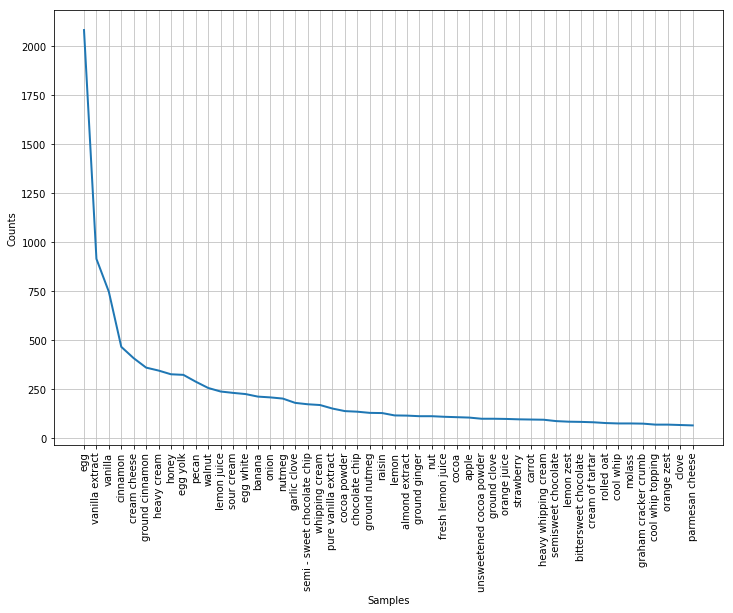

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 8))
# plt.ylim(0,120)
fdist.plot(50,cumulative=False)
# plt.ylim(0,30)
# plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
import string

from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
np.random.seed(23)

In [ ]:
stopwords_list  = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list +=

In [ ]:
stopwords_list[-20:]

In [76]:
# import spacy

ModuleNotFoundError: No module named 'spacy'

In [82]:
# !python -m spacy download en

    100% |████████████████████████████████| 11.1MB 1.4MB/s ta 0:00:01118% |██▊                             | 942kB 617kB/s eta 0:00:17
  Running setup.py install for en-core-web-sm ... done
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import spacy

In [85]:
nlp = spacy.load('en')

In [112]:
desserts[3204]['instructions']

test_instructions = ''

for instr in desserts[3204]['instructions']:
    test_instructions += instr['text'] + ' '
    
print(test_instructions)

Preheat oven to 325 degrees F (165 degrees C). Grease and flour three 9 inch round cake pans. Cream together butter, 2 cups sugar, eggs, and vanilla. Sift together flour, baking powder, and salt. Add flour mixture alternately with milk into egg mixture. Divide batter into 3 parts. Fill two pans with plain batter. Add spices, raisins, and nuts into remaining batter, and pour batter into third pan. Bake for 25 minutes, or until done. Cool layers on wire racks. Mix together orange juice and rind, 2 cups coconut, 2 cups sugar, boiling water, and cornstarch in a 2 quart pan. Bring to a boil, and cook until mixture falls in lumps from a spoon. Put layers together with filling, placing spiced layer in the center. Ice cake with Seven Minute Frosting, and cover with remaining coconut. 


In [113]:
parsed_text = nlp(test_instructions)

In [114]:
parsed_text

Preheat oven to 325 degrees F (165 degrees C). Grease and flour three 9 inch round cake pans. Cream together butter, 2 cups sugar, eggs, and vanilla. Sift together flour, baking powder, and salt. Add flour mixture alternately with milk into egg mixture. Divide batter into 3 parts. Fill two pans with plain batter. Add spices, raisins, and nuts into remaining batter, and pour batter into third pan. Bake for 25 minutes, or until done. Cool layers on wire racks. Mix together orange juice and rind, 2 cups coconut, 2 cups sugar, boiling water, and cornstarch in a 2 quart pan. Bring to a boil, and cook until mixture falls in lumps from a spoon. Put layers together with filling, placing spiced layer in the center. Ice cake with Seven Minute Frosting, and cover with remaining coconut. 

In [118]:
for num, entity in enumerate(nlp(test_instructions).ents):
    print(num+1,'Entity: ',entity, entity.label_)

1 Entity:  325 degrees F QUANTITY
2 Entity:  165 degrees QUANTITY
3 Entity:  three 9 inch QUANTITY
4 Entity:  2 CARDINAL
5 Entity:  3 CARDINAL
6 Entity:  two CARDINAL
7 Entity:  third ORDINAL
8 Entity:  25 minutes TIME
9 Entity:  2 CARDINAL
10 Entity:  2 CARDINAL
11 Entity:  2 CARDINAL
12 Entity:  Seven Minute Frosting TIME


In [123]:
token_pos = [token.pos for token in nlp(test_instructions)]
tokens = [token for token in nlp(test_instructions)]
sd = list(zip(tokens, token_pos))
sd = pd.DataFrame(sd, columns=['token','pos'])
sd.head()

,token,pos
0,Preheat,96
1,oven,100
2,to,85
3,325,93
4,degrees,92


In [124]:
sd

,token,pos
0,Preheat,96
1,oven,100
2,to,85
3,325,93
4,degrees,92
5,F,96
6,(,97
7,165,93
8,degrees,92
9,C,96


In [125]:
max_num_words = 1000
max_seg_length = 100
tokenizer = Tokenizer(num_words=max_num_words)